In [1]:
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

ACCRE has three scheduler partitions that groups can get access to which consist of machines each with 4 GPU cards. Each partition is named after the nvidia processor generation that it contains, from oldest to newest: maxwell, pascal, and turing. GPU nodes are requested per-GPU, and users can request up to 4 GPUs per node. For each GPU the user is allocated up to one quarter of the machine's RAM and CPU cores. All of the current GPU-accelerated hardware is also connected to a special high-speed RoCE (RDMA over converged ethernet) network allowing for memory sharing on large-scale multi-GPU jobs, so users can also request multiple servers for analysis that requires more than four GPU cards.

Import Dataframe

In [2]:
raw = pd.read_csv('../data/accre-gpu-jobs-2022-v2.csv',
                 on_bad_lines='warn',
                 engine='python') 

Skipping line 124084: Expected 12 fields in line 124084, saw 13
Skipping line 124809: Expected 12 fields in line 124809, saw 13


In [3]:
raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 336950 entries, 0 to 336949
Data columns (total 12 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   JOBID      336950 non-null  object
 1   ACCOUNT    336950 non-null  object
 2   USER       336950 non-null  object
 3   USEDMEM    336950 non-null  object
 4   REQTIME    336950 non-null  object
 5   USEDTIME   336950 non-null  object
 6   NODES      336950 non-null  int64 
 7   CPUS       336950 non-null  int64 
 8   GPUS       336950 non-null  int64 
 9   PARTITION  336950 non-null  object
 10  EXITCODE   336950 non-null  object
 11  STATE      336950 non-null  object
dtypes: int64(3), object(9)
memory usage: 30.8+ MB


In [4]:
# Use .copy when subsetting!!!!
com_job=raw[raw["STATE"] == 'COMPLETED'].copy()
com_job

,JOBID,ACCOUNT,USER,USEDMEM,REQTIME,USEDTIME,NODES,CPUS,GPUS,PARTITION,EXITCODE,STATE
0,32880657,malanga,arline,18.66M,2-00:00:00,00:13:13,1,2,1,pascal,0:0,COMPLETED
1,32880701,glasshouse,brady,0,05:00:00,00:00:22,1,3,1,maxwell,0:0,COMPLETED
2,32880718,glasshouse,brady,402.32M,05:00:00,00:08:57,1,3,1,maxwell,0:0,COMPLETED
3,32880719,glasshouse,brady,417.62M,20:00:00,05:09:46,1,1,1,pascal,0:0,COMPLETED
4,32880720,glasshouse,brady,450.09M,15:00:00,04:11:10,1,1,1,pascal,0:0,COMPLETED
...,...,...,...,...,...,...,...,...,...,...,...,...
336933,46753813,harovin,shannon,137.96M,5-00:00:00,00:00:52,1,1,1,turing,0:0,COMPLETED
336934,46753820_26,harovin,porsha,5093.70M,5-00:00:00,00:34:51,1,6,1,turing,0:0,COMPLETED
336936,46753823,harovin,shannon,156.21M,5-00:00:00,00:04:03,1,1,1,turing,0:0,COMPLETED
336942,46754095,harovin,shannon,2820.52M,5-00:00:00,00:11:13,1,1,1,turing,0:0,COMPLETED


1. What is the distribution of per-GPU main memory usage over all runtime-weighed jobs in each partition? Knowing this will help ACCRE to understand our users memory needs for future hardware purchases.

In [5]:
com_job['USEDMEM'] = com_job['USEDMEM'].str.replace('M', '').astype(float)
com_job['REQTIME'] = pd.to_timedelta(com_job['REQTIME'].str.replace('-',' days ')).dt.total_seconds()
com_job['USEDTIME'] = pd.to_timedelta(com_job['USEDTIME'].str.replace('-',' days ')).dt.total_seconds()
#com_job['CPUS'] = com_job['CPUS'].astype(str)
com_job['GPUS'] = com_job['GPUS'].astype(str)
com_job.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 283333 entries, 0 to 336948
Data columns (total 12 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   JOBID      283333 non-null  object 
 1   ACCOUNT    283333 non-null  object 
 2   USER       283333 non-null  object 
 3   USEDMEM    283333 non-null  float64
 4   REQTIME    283333 non-null  float64
 5   USEDTIME   283333 non-null  float64
 6   NODES      283333 non-null  int64  
 7   CPUS       283333 non-null  int64  
 8   GPUS       283333 non-null  object 
 9   PARTITION  283333 non-null  object 
 10  EXITCODE   283333 non-null  object 
 11  STATE      283333 non-null  object 
dtypes: float64(3), int64(2), object(7)
memory usage: 28.1+ MB


In [6]:
com_job

,JOBID,ACCOUNT,USER,USEDMEM,REQTIME,USEDTIME,NODES,CPUS,GPUS,PARTITION,EXITCODE,STATE
0,32880657,malanga,arline,18.66,172800.0,793.0,1,2,1,pascal,0:0,COMPLETED
1,32880701,glasshouse,brady,0.00,18000.0,22.0,1,3,1,maxwell,0:0,COMPLETED
2,32880718,glasshouse,brady,402.32,18000.0,537.0,1,3,1,maxwell,0:0,COMPLETED
3,32880719,glasshouse,brady,417.62,72000.0,18586.0,1,1,1,pascal,0:0,COMPLETED
4,32880720,glasshouse,brady,450.09,54000.0,15070.0,1,1,1,pascal,0:0,COMPLETED
...,...,...,...,...,...,...,...,...,...,...,...,...
336933,46753813,harovin,shannon,137.96,432000.0,52.0,1,1,1,turing,0:0,COMPLETED
336934,46753820_26,harovin,porsha,5093.70,432000.0,2091.0,1,6,1,turing,0:0,COMPLETED
336936,46753823,harovin,shannon,156.21,432000.0,243.0,1,1,1,turing,0:0,COMPLETED
336942,46754095,harovin,shannon,2820.52,432000.0,673.0,1,1,1,turing,0:0,COMPLETED


In [7]:
# Would it be useful for the scheduler to know the difference between requested and used time.
# Would it be useful to know the distribution of the ratio of requested vs. used time for specific users
com_job["req_used_dif"] = ((com_job['REQTIME'] - com_job['USEDTIME']))
com_job["req_used_ratio"] = ((com_job['USEDTIME'] / com_job['REQTIME']))
com_job

,JOBID,ACCOUNT,USER,USEDMEM,REQTIME,USEDTIME,NODES,CPUS,GPUS,PARTITION,EXITCODE,STATE,req_used_dif,req_used_ratio
0,32880657,malanga,arline,18.66,172800.0,793.0,1,2,1,pascal,0:0,COMPLETED,172007.0,0.004589
1,32880701,glasshouse,brady,0.00,18000.0,22.0,1,3,1,maxwell,0:0,COMPLETED,17978.0,0.001222
2,32880718,glasshouse,brady,402.32,18000.0,537.0,1,3,1,maxwell,0:0,COMPLETED,17463.0,0.029833
3,32880719,glasshouse,brady,417.62,72000.0,18586.0,1,1,1,pascal,0:0,COMPLETED,53414.0,0.258139
4,32880720,glasshouse,brady,450.09,54000.0,15070.0,1,1,1,pascal,0:0,COMPLETED,38930.0,0.279074
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
336933,46753813,harovin,shannon,137.96,432000.0,52.0,1,1,1,turing,0:0,COMPLETED,431948.0,0.000120
336934,46753820_26,harovin,porsha,5093.70,432000.0,2091.0,1,6,1,turing,0:0,COMPLETED,429909.0,0.004840
336936,46753823,harovin,shannon,156.21,432000.0,243.0,1,1,1,turing,0:0,COMPLETED,431757.0,0.000563
336942,46754095,harovin,shannon,2820.52,432000.0,673.0,1,1,1,turing,0:0,COMPLETED,431327.0,0.001558


In [12]:
com_job["req_used_ratio"].describe()

count    283333.000000
mean          0.054817
std           0.154017
min           0.000000
25%           0.001139
50%           0.005472
75%           0.014468
max           1.934722
Name: req_used_ratio, dtype: float64

In [8]:
#I'm going to look at maxwell first
maxwell_pivoted = (
    com_job
    .loc[com_job['PARTITION'].isin(['maxwell'])]
    .pivot_table(values = 'req_used_ratio',
                  index = 'ACCOUNT',
                  columns = 'GPUS')
    
)
maxwell_pivoted

GPUS,1,12,16,18,2,24,3,4,40,6,8
ACCOUNT,,,,,,,,,,,
bertanne,0.123630,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
clara,0.724716,NaN,NaN,NaN,NaN,NaN,NaN,0.107917,NaN,NaN,NaN
glasshouse,0.016467,0.062581,0.04125,0.064014,0.008692,0.445889,NaN,0.047300,NaN,0.106673,0.027182
orange,0.001264,NaN,NaN,NaN,NaN,NaN,NaN,0.716913,NaN,NaN,NaN
pasilla,0.013634,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00125,NaN,NaN
plumcot,0.041370,NaN,NaN,NaN,0.000064,NaN,NaN,NaN,NaN,NaN,NaN
summer,NaN,NaN,NaN,NaN,1.000098,NaN,NaN,NaN,NaN,NaN,NaN
white,0.281597,NaN,NaN,NaN,NaN,NaN,0.639727,0.530425,NaN,NaN,NaN


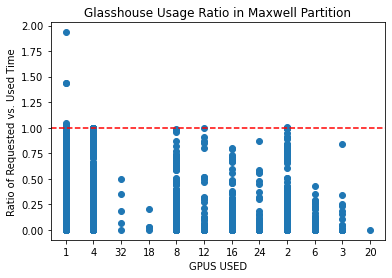

In [9]:
#USAGE RATIO OF glasshouse account on Maxwell Partition
plot_df = com_job.loc[com_job['ACCOUNT'] == 'glasshouse']
plt.scatter(plot_df['GPUS'], plot_df["req_used_ratio"])
plt.xlabel("GPUS USED")
plt.ylabel("Ratio of Requested vs. Used Time")
plt.title("Glasshouse Usage Ratio in Maxwell Partition")
plt.axhline(y=1, color='r', linestyle='--')

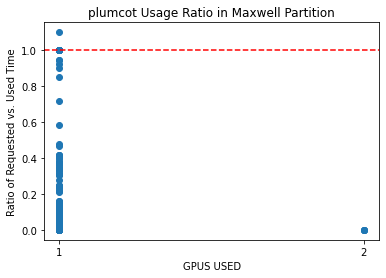

In [10]:
#USAGE RATIO OF glasshouse account on Maxwell Partition
plot_df = com_job.loc[com_job['ACCOUNT'] == 'plumcot']
plt.scatter(plot_df['GPUS'], plot_df["req_used_ratio"])
plt.xlabel("GPUS USED")
plt.ylabel("Ratio of Requested vs. Used Time")
plt.title("plumcot Usage Ratio in Maxwell Partition")
plt.axhline(y=1, color='r', linestyle='--')

In [11]:
CPC.plot(kind = 'bar');
plt.xlabel("Continents")
plt.ylabel("Country Count")
plt.title("Number of Countries per Continent")
plt.legend()
plt.xticks(rotation=45)

NameError: name 'CPC' is not defined

The main objectives of this project are to examine the following questions:
1. What is the distribution of per-GPU main memory usage over all runtime-weighed jobs in each partition? Knowing this will help ACCRE to understand our users memory needs for future hardware purchases.
2. What is the distribution of the number of GPUs in each job (runtime-weighted) for each partition? What fraction of runtime-weighted and GPU-weighted jobs are using more than 4 GPUs and thus probably using the RoCE networking? Is this fraction different for each partition?
3. What is the total runtime usage per-gpu (i.e. multiply runtime by the number of gpus) in each of the 3 partitions over the last year?
4. What is the distribution of different groups and users accessing each partition? In each partition, who are the top users, and do they represent a majority of the runtime-weighted jobs on the partition?
5. Currently there is a 5 day limit on runtime for GPU jobs, although some users have been asking for extensions. What is the distribution of requested runtime and actual runtime on jobs on each partition? Do users really need more time, or are they simply always requesting the maximum?